In [1]:
import pandas as pd

In [2]:
def calculate_congestion_level(before, decrease):
    if before == 'High' and decrease == 'Decrease':
        return 'Medium'
    elif before == 'High' and decrease == 'Same':
        return 'High'
    elif before == 'Medium' and decrease == 'Decrease':
        return 'Low'
    elif before == 'Medium' and decrease == 'Same':
        return 'Medium'
    elif before == 'Low' and decrease == 'Decrease':
        return 'Low'
    elif before == 'Low' and decrease == 'Same':
        return 'Low'
    raise ValueError('Invalid input')

In [12]:
utilities = []
for congestion in ['High', 'Medium', 'Low']:
    for congestion_decrease in ['Decrease', 'Same']:
        for construction in ['Expand', 'Invest', 'Do Nothing']:
            for delay in ['Delay', 'No Delay', 'NA']:
                for hire in ['Yes', 'No']:
                    utility = 0
                    if delay == 'NA' and construction != 'Do Nothing':
                        utilities.append('x')
                        continue
                    elif delay == 'Do Nothing' and congestion_decrease == 'Decrease':
                        utilities.append('x')
                        continue
                    elif construction == 'Do Nothing' and delay != 'NA':
                        utilities.append('x')
                        continue
                    else: 
                        final_congestion = calculate_congestion_level(congestion, congestion_decrease)
                        if final_congestion == 'High':
                            utility -= 4000
                        elif final_congestion == 'Medium':
                            utility -= 2000
                        elif final_congestion == 'Low':
                            utility -= 750
                            
                        if construction == 'Expand':
                            utility -= 1000
                        elif construction == 'Invest':
                            utility -= 2000
                        elif construction == 'Do Nothing':
                            utility -= 0
                            
                        if delay == 'Delay' and construction == 'Expand':
                            utility -= 500
                        elif delay == 'Delay' and construction == 'Invest':
                            utility -= 500
                            
                        if hire == 'Yes':
                            utility -= 50
                        
                        utilities.append(utility)
                    
                    

In [9]:
df = pd.DataFrame(utilities, columns=['Utility'])
df.to_csv('mid23.csv', index=False)

In [13]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [16]:
model = pm.Model()

with model:
    alpha = pm.Uniform("alpha", lower=7, upper=10)
    beta = pm.Uniform("beta", lower=1/120, upper=1/80)
    p = pm.Beta("p", alpha=2, beta=5)
    
    c1 = pm.Gamma("c1", alpha=alpha, beta=beta, observed=900)
    c2 = pm.Gamma("c2", alpha=alpha, beta=beta, observed=1500)
    c3 = pm.Gamma("c3", alpha=alpha, beta=beta)
    
    l1 = pm.Binomial("l1", n=9, p=p, observed=4 - 1)
    l2 = pm.Binomial("l2", n=9, p=p, observed=8 - 1)
    l3 = 1 + pm.Binomial("l3", n=9, p=p)
    
    Uc2 = pm.Deterministic("Uc2", (pm.math.exp(-0.0015 * c2) - pm.math.exp(-0.0015 * 3500)) / (1 - pm.math.exp(-0.0015 * 3500)))
    Uc3 = pm.Deterministic("Uc3", (pm.math.exp(-0.0015 * c3) - pm.math.exp(-0.0015 * 3500)) / (1 - pm.math.exp(-0.0015 * 3500)))
    
    Ul2 = pm.Deterministic("Ul2", ((1 - pm.math.exp(-0.3*l2)) - (1 - pm.math.exp(-0.3*1)))/((1 - pm.math.exp(-0.3*10)) - (1 - pm.math.exp(-0.3*1))))
    Ul3 = pm.Deterministic("Ul3", ((1 - pm.math.exp(-0.3*l3)) - (1 - pm.math.exp(-0.3*1)))/((1 - pm.math.exp(-0.3*10)) - (1 - pm.math.exp(-0.3*1))))
    
    U2 = pm.Deterministic("U2", 0.3 * Uc2 + 0.5 * Ul2 + 0.2 * Uc2 * Ul2)
    U3 = pm.Deterministic("U3", 0.3 * Uc3 + 0.5 * Ul3 + 0.2 * Uc3 * Ul3)
    


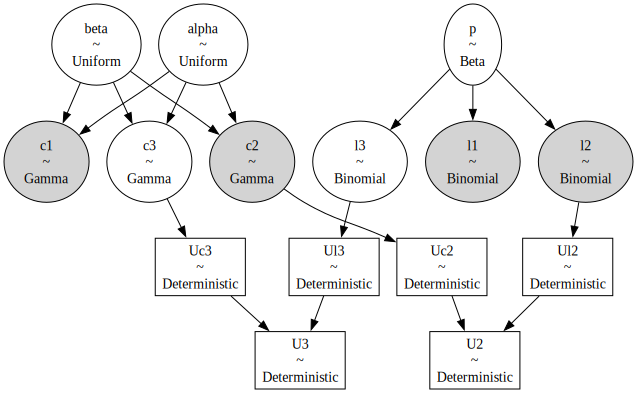

In [17]:
pm.model_to_graphviz(model)

In [25]:
with model:
    trace = pm.sample(draws=40000,tune=2000,chains=8, random_seed=0)

Multiprocess sampling (8 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, beta, p, c3]
>Metropolis: [l3]


Sampling 8 chains for 2_000 tune and 40_000 draw iterations (16_000 + 320_000 draws total) took 101 seconds.


C:\Users\0xc00\.conda\envs\MIE566\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\0xc00\.conda\envs\MIE566\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\0xc00\.conda\envs\MIE566\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l3,4.323,1.720,1.000,7.000,0.008,0.005,51812.0,61732.0,1.0
alpha,8.932,0.775,7.507,10.000,0.002,0.001,239347.0,188777.0,1.0
beta,0.010,0.001,0.008,0.012,0.000,0.000,275227.0,212125.0,1.0
p,0.480,0.098,0.296,0.662,0.000,0.000,123941.0,186140.0,1.0
c3,935.981,335.712,358.285,1567.641,0.654,0.463,250559.0,216849.0,1.0
Uc2,0.101,0.000,0.101,0.101,0.000,0.000,320000.0,320000.0,NaN
Uc3,0.271,0.124,0.057,0.500,0.000,0.000,250559.0,216849.0,1.0
Ul2,0.895,0.000,0.895,0.895,0.000,0.000,320000.0,320000.0,NaN
Ul3,0.738,0.177,0.484,0.975,0.001,0.001,51812.0,61732.0,1.0
U2,0.496,0.000,0.496,0.496,0.000,0.000,320000.0,320000.0,NaN


C:\Users\0xc00\.conda\envs\MIE566\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\0xc00\.conda\envs\MIE566\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\0xc00\.conda\envs\MIE566\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


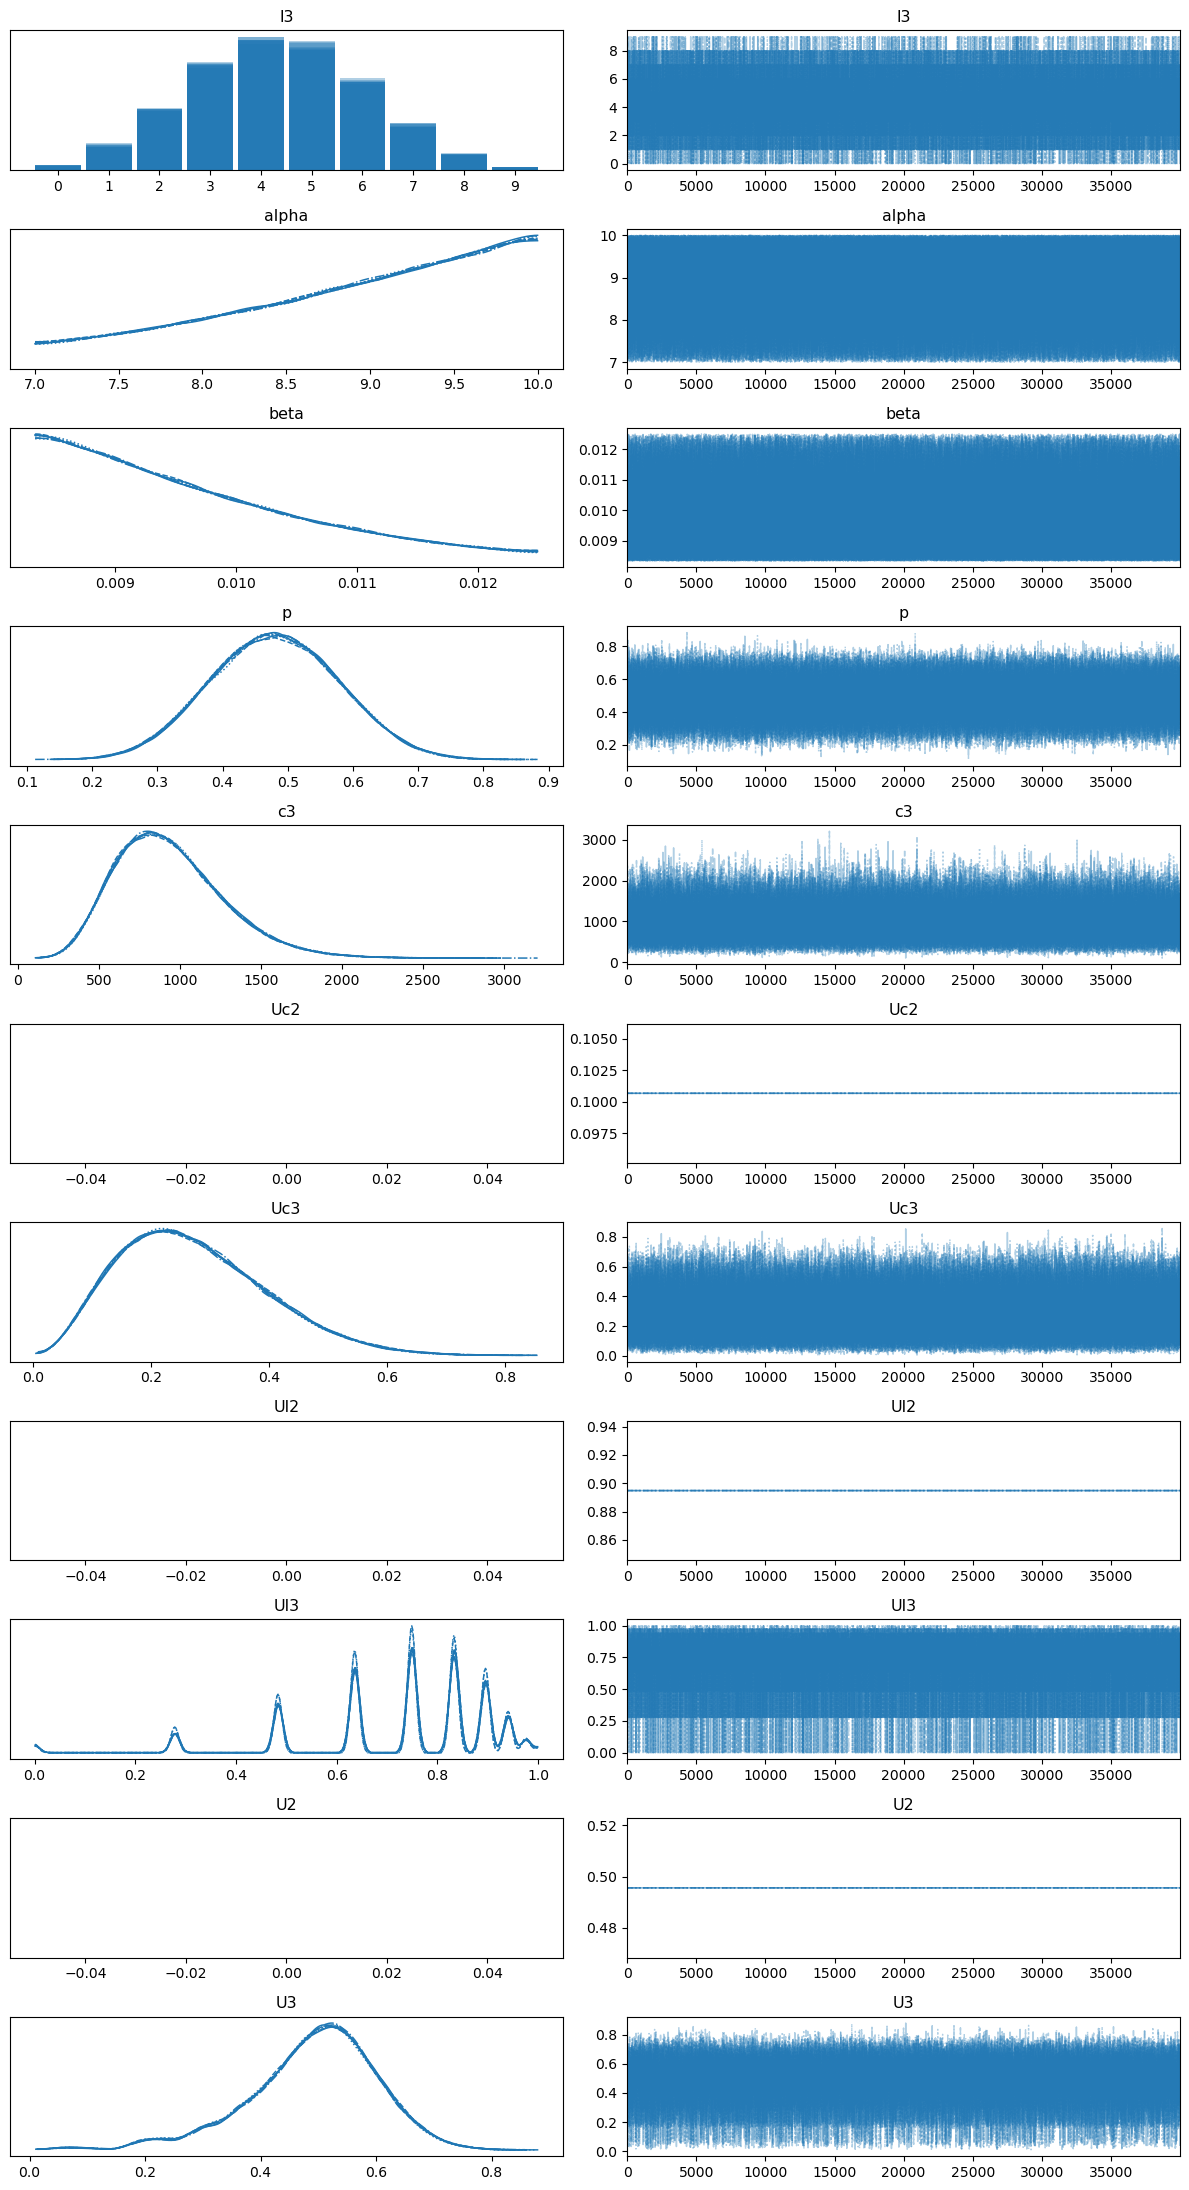

In [26]:
with model:
    display(az.summary(trace))
    az.plot_trace(trace)
    plt.tight_layout()

In [27]:
(trace['posterior']['U2']).to_numpy().mean()

0.4956421162765917

In [28]:
(trace['posterior']['U3']).to_numpy().mean()

0.4903381090699917